# Concept Shift Demonstration with Random Forest

This notebook illustrates **concept shift** using the Red Wine Quality dataset. We will:

1. Load the dataset  
2. Define and simulate a concept shift by changing the label threshold  
3. Train a Random Forest on the original concept  
4. Evaluate on the shifted concept  
5. Visualize the impact on performance and feature importance  


## 1. Load Data

In [1]:
import pandas as pd

# Load the red wine quality dataset
df = pd.read_csv('winequality-red.csv', sep=',')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Define Concept Shift

In [2]:
# Ensure 'quality' column exists
assert 'quality' in df.columns, "Column 'quality' not found!"

# Original concept: label=1 if quality >= 7
df['label_train'] = (df['quality'] >= 7).astype(int)

# Shifted concept: label=1 if quality >= 6
df['label_test'] = (df['quality'] >= 6).astype(int)

df[['quality', 'label_train', 'label_test']].drop_duplicates().sort_values('quality')

,quality,label_train,label_test
459,3,0,0
18,4,0,0
0,5,0,0
3,6,0,1
7,7,1,1
267,8,1,1


## 3. Split Data

In [3]:
from sklearn.model_selection import train_test_split

features = df.columns.drop(['quality', 'label_train', 'label_test'])
X = df[features]

# Split using original labels
X_train, X_test, y_train, y_test_original = train_test_split(
    X, df['label_train'], test_size=0.3, random_state=42
)

# Apply shifted concept to the test set
y_test = df.loc[y_test_original.index, 'label_test']

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((1119, 11),
 (480, 11),
 label_train
 0    969
 1    150
 Name: count, dtype: int64,
 label_test
 1    267
 0    213
 Name: count, dtype: int64)

## 4. Train Random Forest on Original Concept

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Evaluate on Shifted Concept

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = clf.predict(X_test)

print("Classification Report on Shifted Test Labels:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report on Shifted Test Labels:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       213
           1       1.00      0.20      0.34       267

    accuracy                           0.56       480
   macro avg       0.75      0.60      0.50       480
weighted avg       0.78      0.56      0.48       480

Confusion Matrix:
[[213   0]
 [213  54]]


## 6. Visualize Label Distributions

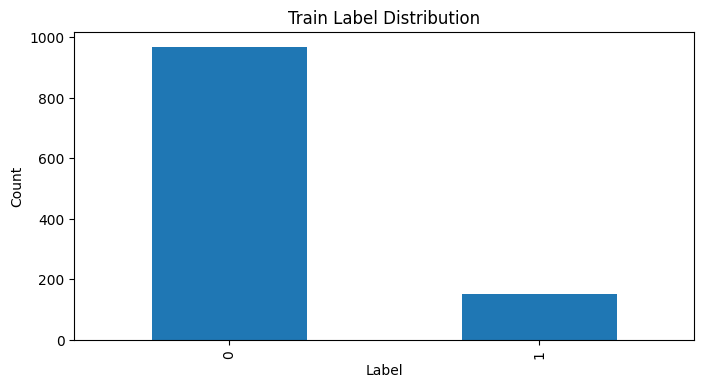

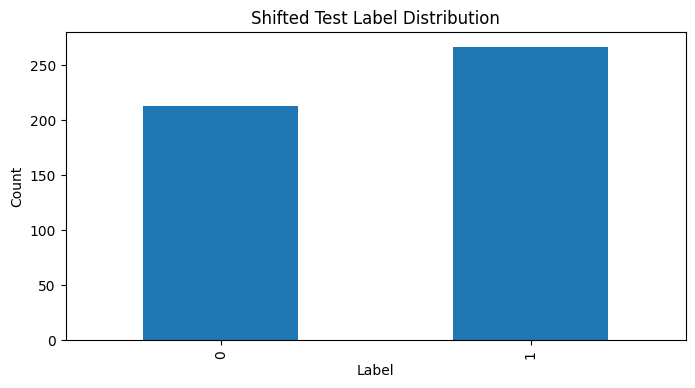

In [6]:
import matplotlib.pyplot as plt

# Plot train vs shifted test label distribution
plt.figure(figsize=(8,4))
y_train.value_counts().sort_index().plot(kind='bar', title='Train Label Distribution')
plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

plt.figure(figsize=(8,4))
y_test.value_counts().sort_index().plot(kind='bar', title='Shifted Test Label Distribution')
plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

## 7. Feature Importance Comparison

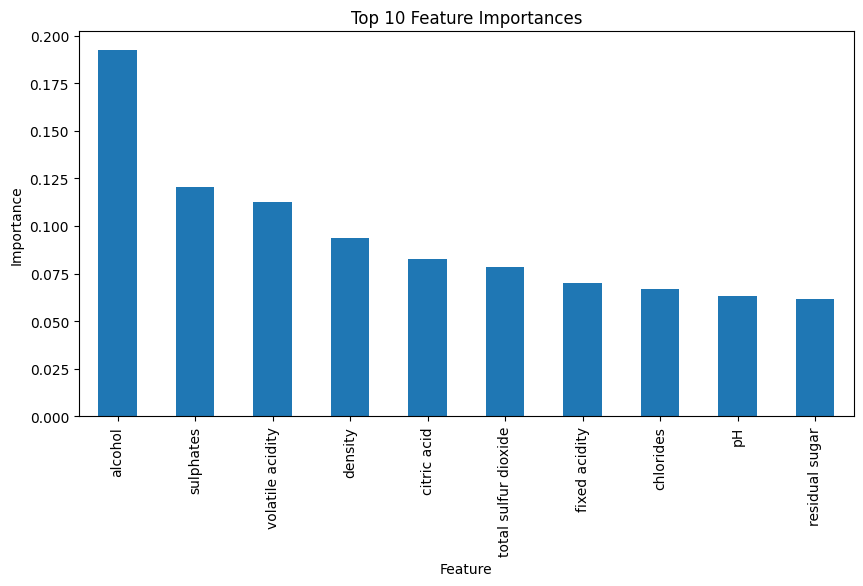

In [7]:
import pandas as pd

# Get feature importances
feat_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(10).plot(kind='bar', title='Top 10 Feature Importances')
plt.xlabel('Feature'); plt.ylabel('Importance'); plt.show()

## Conclusion

- The Random Forest trained on the original label threshold performs poorly when evaluated under the shifted threshold.
- This demonstrates how changes in the decision rule (concept shift) can drastically affect model performance.
- Monitoring for label distribution changes and retraining as guidelines evolve is critical in production.